# Text Analysis with Project Gutenberg

In this assignment, we'll continue to investigate text as data with an important archive, Project Gutenberg [https://www.gutenberg.org/]. We'll apply some of the coding strategies to text data from the archive as an example of how we might approach corpus analysis.

In [1]:
!pip install contractions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from textblob import TextBlob as tb 
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
import re
import contractions


/Users/michaelsmith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/michaelsmith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, twitter_samples
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, TweetTokenizer, RegexpTokenizer
from nltk.util import ngrams
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('brown')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/michaelsmith/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /U

In [4]:
# These are the jeremiad keywords
jeremiad_keywords = set(['sin', 'salvation', 'lament', 'condemn', 'righteous', 'immoral', 
                      'judgment', 'repent', 'slavery', 'white', 'america', 'master',
                      'colored', 'christian', 'freedom', 'slave'
                      ])
jeremiad_labels = list(jeremiad_keywords)

# Keyword coding manually identified terms
keywords3 = {}
keyword_counts3 = {}

def wn_keyword_count3(words):
    for term in jeremiad_keywords:
        keyword_counts3[term] = 0
    
    for word in words:
        for term in jeremiad_keywords:
            if word.find(term) != -1:
                keyword_counts3[term] += 1

    return keyword_counts3       


In [5]:
# Rokeach's Theory of Human Values: Terminal values

COMFORT = set([
             'comfort', 'cheer', 'console', 'consolation', 'relief', 'solace' 
])

EXCITE = set([
              'excitement', 'excite', 'appetite', 'ardor', 'avid', 'desire', 
              'eagerness', 'enthusiasm', 'hunger', 'keenness', 'fun', 'thrill'
              'exhilarate', 'amuse', 'amusement'
])

ACCOMPLISH = set([
                  'accomplishment', 'accomplish', 'achievement', 'achieve', 
                  'attainment', 'attain', 'success', 'triumph', 'succeed'
])

PEACE = set([
             'peace', 'peaceful', 'calm', 'calmness', 'peacefulness', 
             'placidity', 'placid', 'sereneness', 'serenity', 'tranquillity', 
             'tranquility', 'content', 'contented', 'contentment'
])

BEAUTY = set([
              'aesthetic', 'esthetic', 'attractive', 'beautiful', 'lovely', 
              'attractive', 'cute', 'gorgeous', 'handsome', 'pretty', 'elegant',
              'beauty'
])

EQUALITY = set([
                'evenhandedness', 'evenhanded', 'fair-mindedness', 'fair-minded',
                'fairness', 'impartiality', 'impartial', 'justice', 'equality', 
                'equity', 'equitable', 'fair'
])

SECURITY = set([  #I've combined 'national security' and 'family security' in the theory
                'protection', 'protect', 'protected', 'safe', 'safety', 'secure', 'security'
])

FREEDOM = set([
               'autonomy', 'independence', 'independent', 'liberty', 'self-determination', 
               'self-governance', 'self-government', 'sovereignty', 'sovereign',
               'freedom', 'free'
])

HAPPINESS = set([
                 'bliss', 'blissfulness', 'felicity', 'gladness', 'glad',
                 'joy', 'happy', 'happiness', 'blissful', 'joyous' 
])

HARMONY = set([
               'comity', 'compatibility', 'compatible', 'concord', 'harmony', 'harmonious'
])

LOVE = set([
            'affection', 'attachment', 'devotedness', 'devotion', 'fondness', 'passion',
            'affectionate', 'devoted', 'fond', 'passionate', 'sweetheart', 'love', 'lover'
            'girlfriend', 'boyfriend', 'husband', 'wife', 'marriage', 'married', 'wedding',
            'honeymoon' 
])

PLEASURE = set([
               'delight', 'enjoyment', 'gladness', 'gratification', 'enjoy',
                'satisfaction', 'delightful', 'enjoyable', 'pleasure', 'pleasurable',
                'gratifying', 'sex', 'lust'
])

SALVATION = set([
                 'deliverance', 'rescue', 'saved', 'innocent', 'innocence', 'salvation'
                 'redeemed', 'atoned', 'blessed'
])

SELFRESPECT = set([
                   'ego', 'pride', 'prideful', 'self-esteem', 'self-regard'
                   'esteem', 'respect'
])

RECOGNITION = set([
                   'celebrity', 'notoriety', 'renown', 'fame', 'famous', 'respected', 
                   'popular', 'popularity', 'recognition', 'recognized', 'award-winning'
])

FRIENDSHIP = set([
                  'brotherhood', 'sisterhood', 'charity', 'cordiality', 
                  'fellowship', 'friendliness', 'good-fellowship', 
                  'goodwill', 'kindly', 'neighborly', 'friend', 'friendship'
])

WISDOM = set([
              'discernment', 'insight', 'perception', 'perceptiveness', 'perceptivity', 
              'sagaciousness', 'sagacity', 'sageness', 'sapience', 'wisdom', 'wise'
])

terminal_terms = {
    'comfort': COMFORT, 
    'excite': EXCITE, 
    'accomplish': ACCOMPLISH, 
    'peace': PEACE, 
    'beauty': BEAUTY, 
    'equality': EQUALITY, 
    'security': SECURITY, 
    'freedom2': FREEDOM, 
    'happiness': HAPPINESS, 
    'harmony': HARMONY, 
    'love': LOVE, 
    'pleasure': PLEASURE, 
    'salvation2': SALVATION, 
    'selfrespect': SELFRESPECT, 
    'recognition': RECOGNITION, 
    'friendship': FRIENDSHIP, 
    'wisdom': WISDOM
}

terminal_labels = []
terminal_freqs = {}

def terminal_count(words):
    for term in terminal_terms.keys():
        terminal_freqs[term] = 0

    for word in words:
        for key in terminal_terms.keys():
            terminal_labels.append(key)
            for term in terminal_terms[key]:
                if word.find(term) != -1:
                    terminal_freqs[key] += 1 

    return terminal_freqs


In [6]:
# Rokeach's Theory of Human Values: Instrumental values

# Now, the instrumental values

AMBITIOUS = set([
                 'ambitious', 'ambition', 'striving', 'aspiring', 'go-getting', 'hard-driving', 
                 'self-seeking', 'determined', 'aspire', 'enterprising', 'industrious', 'competitive',
                 'ardent', 'assertive', 'opportunistic'
])

BROADMINDED = set([
                   'broad-minded', 'open-minded', 'liberal', 'nonjudgmental', 'tolerant', 
                   'nonconventional', 'nonorthodox', 'nontraditional', 'progressive', 
                   'radical', 'unconventional', 'unorthodox'
])

CAPABLE = set([
               'capable', 'competent', 'qualified', 'suitable', 'accomplished', 
               'adept', 'masterful', 'proficient', 'seasoned', 'skilled', 'skillful', 
               'prepared', 'well-prepared'
])

CHEERFUL = set([
                'cheerful', 'blithe', 'blithesome', 'bright', 'buoyant', 'cheery', 'chipper', 
                'eupeptic', 'gladsome', 'lightsome', 'sunny', 'upbeat', 'winsome'
])

CLEAN = set([
             'clean', 'chaste', 'immaculate', 'pristine', 'spotless', 'unsoiled', 'unstained', 
             'unsullied', 'decent', 'modest', 'healthy'
])

COURAGEOUS = set([
                  'courageous', 'bold', 'brave', 'dauntless', 'fearless', 
                  'gallant', 'greathearted', 'gutsy', 'heroic', 'intrepid', 
                  'lionhearted', 'manful', 'stalwart', 'stout', 'stouthearted', 
                  'undaunted', 'valiant', 'valorous'
])
            
FORGIVING = set([
                 'forgiving', 'caring', 'compassionate', 'considerate', 'cordial', 
                 'doting', 'friendly', 'humane', 'kind', 'understanding', 'warmhearted'
])

HELPFUL = set([
               'helpful', 'advantageous', 'beneficent', 'beneficial', 'benignant', 
               'favorable', 'kindly', 'salutary', 'kind', 'generous'
])

HONEST = set([
              'honest', 'truthful', 'veracious', 'candid', 'forthright', 'believable', 
              'credible', 'trustworthy', 'scrupulous'
])

IMAGINATIVE = set([
                   'imaginative', 'creative', 'arty', 'fanciful', 'clever', 'ingenious', 
                   'innovative', 'inventive', 'artful', 'artsy'
])

INDEPENDENT = set([
                   'independent', 'self-reliant', 'self-sufficient', 'self-supporting', 
                   'self-sustaining', 'autonomous', 'mature', 'sovereign'
])
            
INTELLECTUAL = set([
                    'intellectual', 'smart', 'cerebral', 'eggheaded', 'geeky', 'highbrow',
                    'erudite', 'learned', 'literate', 'polymath', 'scholarly', 'well-read',
                    'academic', 'bookish', 'professorial', 'didactic', 'pedantic', 
                    'educated', 'schooled'
])

LOGICAL = set([
               'logical', 'rational', 'analytical', 'coherent', 'reasonable', 'reasoned'
])

LOVING = set([
              'loving', 'affectionate', 'adoring', 'devoted', 'fond', 'tender', 
              'tenderhearted', 'caring', 'considerate', 'ardent', 'fervent', 
              'impassioned', 'passionate'
])

OBEDIENT = set([
                'obedient', 'amenable', 'biddable', 'compliant', 'conformable', 
                'docile', 'law-abiding', 'submissive', 'tractable', 'acquiescent',
                'yielding', 'tame', 'meek'
])

POLITE = set([
              'polite', 'civil', 'courteous', 'genteel', 'gracious', 'mannerly', 'well-bred',
              'solicitous'
])

RESPONSIBLE = set([
                   'responsible', 'dependable', 'reliable', 'accountable'
])
            
SELFCONTROL = set([
                   'self-control', 'restrained', 'sober', 'reserved', 'reticent', 
                   'levelheaded', 'pragmatic', 'sensible', 'steadfast', 'steady'
])

instrumental_terms = {
    'ambitious': AMBITIOUS, 
    'broadminded': BROADMINDED, 
    'capable': CAPABLE, 
    'cheerful': CHEERFUL, 
    'clean': CLEAN, 
    'courageous': COURAGEOUS, 
    'forgiving': FORGIVING, 
    'helpful': HELPFUL, 
    'honest': HONEST, 
    'imaginative': IMAGINATIVE, 
    'independent': INDEPENDENT, 
    'intellectual': INTELLECTUAL, 
    'logical': LOGICAL, 
    'loving': LOVING, 
    'obedient': OBEDIENT, 
    'polite': POLITE, 
    'responsible': RESPONSIBLE, 
    'selfcontrol': SELFCONTROL
}

instrumental_labels = []
instrumental_freqs = {}

def instrumental_count(words):
    for term in instrumental_terms.keys():
        instrumental_freqs[term] = 0

    for word in words:
        for key in instrumental_terms.keys():
            instrumental_labels.append(key)
            for term in instrumental_terms[key]:
                if word.find(term) != -1:
                    instrumental_freqs[key] += 1 

    return instrumental_freqs


First, we get the text from the Project Gutenberg archive. I'm going to scrape the text of books by Frederick Douglass in the archive, including two of his most famous works: *Narrative of the Life of Frederick Douglass, an American Slave* and *My Bondage and My Freedom*.

https://www.gutenberg.org/ebooks/author/34510

In [7]:
URLs = set([
    'https://www.gutenberg.org/cache/epub/65238/pg65238-images.html',
    'https://www.gutenberg.org/cache/epub/1155/pg1155-images.html',
    'https://www.gutenberg.org/cache/epub/61262/pg61262-images.html'
    # 'https://www.gutenberg.org/cache/epub/66446/pg66446-images.html',
    # 'https://www.gutenberg.org/cache/epub/863/pg863-images.html',
    # 'https://www.gutenberg.org/cache/epub/58866/pg58866-images.html',
    # 'https://www.gutenberg.org/cache/epub/69087/pg69087-images.html'
])

books = {}

import requests
from boilerpy3 import extractors

extractor = extractors.ArticleExtractor()
for URL in URLs:
    try:
        # Make request to URL
        resp = requests.get(URL)

        # Pass HTML to Extractor
        content = extractor.get_content(resp.text)
        content = str(content).replace('\r', '')
        books[URL] = str(content).replace('\n', ' ')

    except:
        print("Can not open URL.")

## Content Coding

In this section, we'll do keyword coding and plot a graph of co-occurrences.

In [8]:
books_df = pd.DataFrame()
content1_df = pd.DataFrame()
content2_df = pd.DataFrame()
content3_df = pd.DataFrame()
bookscoded_df = pd.DataFrame()

for book in books.keys():
    sentences = nltk.sent_tokenize(books[book])
    sent2 = [t.lower() for t in sentences] 
    for term in sent2:
        words = nltk.word_tokenize(term)
        content_coding1 = pd.Series(wn_keyword_count3(words), index=list(jeremiad_labels))
        content1_df = content1_df.append(content_coding1, ignore_index=True)
        content_coding2 = pd.Series(terminal_count(words), index=list(terminal_terms.keys()))
        content2_df = content2_df.append(content_coding2, ignore_index=True)
        content_coding3 = pd.Series(instrumental_count(words), index=list(instrumental_terms.keys()))
        content3_df = content3_df.append(content_coding3, ignore_index=True)
    sent2coded_df = pd.concat([content1_df, content2_df, content3_df], axis=1)
    bookscoded_df = bookscoded_df.append(sent2coded_df, ignore_index=True)

bookscoded_df

/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_73947/777372394.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content1_df = content1_df.append(content_coding1, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_73947/777372394.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content2_df = content2_df.append(content_coding2, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_73947/777372394.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  content3_df = content3_df.append(content_coding3, ignore_index=True)
/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_73947/777372394.py:13: FutureWarning: The frame.append method is deprecated and wil

KeyboardInterrupt: 

In [ ]:

themes_present = np.where(bookscoded_df.mean() > 0, True, False)
themeslimited_df = bookscoded_df.loc[:, themes_present]
themeslimited_df

,lament,condemn,christian,repent,slavery,white,slave,salvation,judgment,colored,...,honest,imaginative,independent,intellectual,logical,loving,obedient,polite,responsible,selfcontrol
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28134,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
themes_cofreq = themeslimited_df.T.dot(themeslimited_df)
themes_dist = 5000 - themes_cofreq
themes_dist  # distance matrix 

,lament,condemn,christian,repent,slavery,white,slave,salvation,judgment,colored,...,honest,imaginative,independent,intellectual,logical,loving,obedient,polite,responsible,selfcontrol
lament,4986.0,5000.0,5000.0,5000.0,5000.0,5000.0,4999.0,5000.0,5000.0,5000.0,...,4995.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
condemn,5000.0,4929.0,4999.0,5000.0,4986.0,5000.0,4978.0,5000.0,5000.0,4999.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,4999.0,5000.0,5000.0,5000.0,5000.0
christian,5000.0,4999.0,4835.0,4999.0,4981.0,4999.0,4906.0,5000.0,5000.0,4992.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,4998.0,5000.0,4993.0,4999.0,5000.0
repent,5000.0,5000.0,4999.0,4978.0,4998.0,4997.0,4996.0,5000.0,5000.0,5000.0,...,4999.0,5000.0,5000.0,5000.0,5000.0,4999.0,5000.0,5000.0,5000.0,5000.0
slavery,5000.0,4986.0,4981.0,4998.0,2972.0,4954.0,2586.0,5000.0,4980.0,4924.0,...,4993.0,4966.0,4999.0,4993.0,4995.0,4981.0,4998.0,4970.0,4987.0,4988.0
white,5000.0,5000.0,4999.0,4997.0,4954.0,4071.0,4730.0,5000.0,4992.0,4799.0,...,4988.0,4929.0,5000.0,4989.0,4993.0,4994.0,4991.0,4980.0,4990.0,5000.0
slave,4999.0,4978.0,4906.0,4996.0,2586.0,4730.0,-3322.0,5000.0,4956.0,4798.0,...,4966.0,4898.0,4990.0,4923.0,4980.0,4938.0,4990.0,4930.0,4973.0,4979.0
salvation,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,4983.0,5000.0,5000.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
judgment,5000.0,5000.0,5000.0,5000.0,4980.0,4992.0,4956.0,5000.0,4831.0,4993.0,...,4987.0,5000.0,5000.0,5000.0,5000.0,4985.0,4994.0,4984.0,4992.0,5000.0
colored,5000.0,4999.0,4992.0,5000.0,4924.0,4799.0,4798.0,5000.0,4993.0,3720.0,...,4976.0,4793.0,4979.0,4979.0,4993.0,4987.0,4999.0,4937.0,4993.0,5000.0


In [ ]:
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
themes_transform = mds.fit_transform(themes_dist)
print(mds.stress_)

52.84104003250709


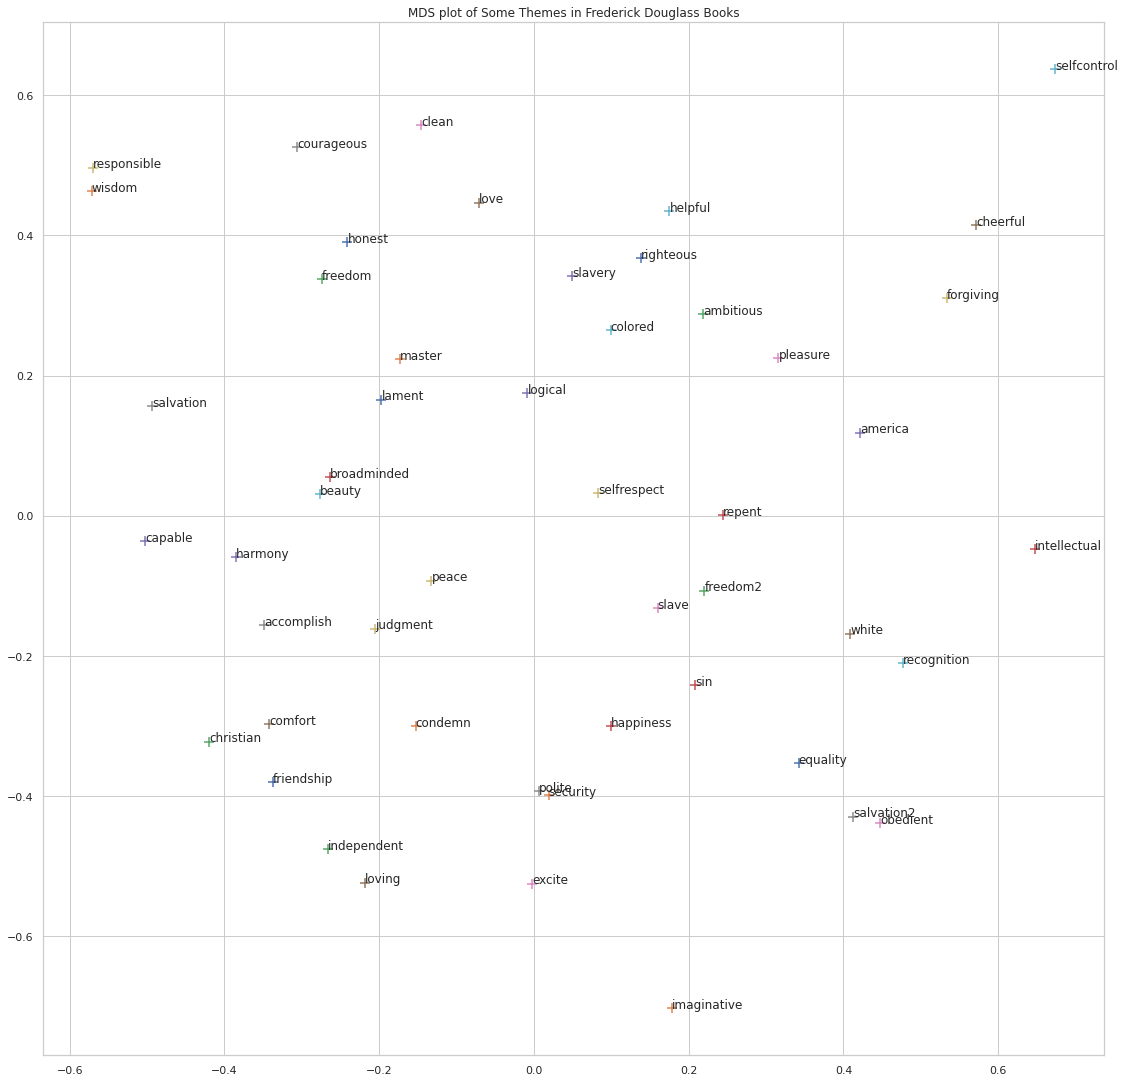

In [ ]:
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(19,19))
i = 0
while i < len(themeslimited_df.columns):
    plt.scatter(themes_transform[i,0], themes_transform[i,1], sizes=(100, 100), marker='+')
    plt.text(themes_transform[i,0], themes_transform[i,1], themeslimited_df.columns[i])
    i += 1
plt.title('MDS plot of Some Themes in Frederick Douglass Books')
plt.show()

## Corpus Analysis

In this section, we'll consider the Douglass books as a single corpus for analysis.

First the content is collected by sentence then by word.

In [ ]:
punctuation = string.punctuation 
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
corpus = []

def clean_text(text):
    for character in string.punctuation:
        text = text.replace(character, '')
    text = text.lower()
    text = contractions.fix(text)
    text_token_list = [word for word in text.split(' ') if word not in stopwords and len(word) > 3]
    text_token_list = [lemmatizer.lemmatize(word) for word in text_token_list]
    text = ' '.join(text_token_list)
    return text

for book in books.keys():
    sentences = nltk.sent_tokenize(books[book])
    for term in sentences:
        words = nltk.word_tokenize(clean_text(term))
        corpus.extend(words)

print(len(corpus))


110074


In [ ]:
punctuation = string.punctuation 
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
corpus2 = []

def clean_text(text):
    for character in string.punctuation:
        text = text.replace(character, '')
    text = text.lower()
    text = contractions.fix(text)
    text_token_list = [word for word in text.split(' ') if word not in stopwords and len(word) > 3]
    text_token_list = [lemmatizer.lemmatize(word) for word in text_token_list]
    text = ' '.join(text_token_list)
    return text

for book in books.keys():
    sentences2 = nltk.sent_tokenize(books[book])
    corpus2.extend(sentences2)

print(len(corpus2))

9671


In [ ]:
vectorizer = CountVectorizer(
    min_df=0.01, 
    max_df=0.75,  
    stop_words='english',
    ngram_range=(1,1)
    )

douglass_tm = vectorizer.fit_transform(corpus2)

# tf_feature_names tells us what word each column in the matrix represents
feature_names = vectorizer.get_feature_names()
douglass_feature_names = vectorizer.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
douglass_dtm = pd.DataFrame(douglass_tm.todense(), columns=douglass_feature_names)
douglass_dtm.head()

,american,away,baltimore,best,better,black,blood,brought,called,came,...,truth,united,way,went,white,work,works,world,years,young
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
douglass_dtm.describe()

,american,away,baltimore,best,better,black,blood,brought,called,came,...,truth,united,way,went,white,work,works,world,years,young
count,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,...,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000,9671.000000
mean,0.023576,0.017165,0.015614,0.010650,0.012512,0.010857,0.014373,0.010754,0.014269,0.015510,...,0.010547,0.016751,0.019853,0.014166,0.025023,0.048392,0.017165,0.016855,0.022231,0.010754
std,0.172165,0.135350,0.135156,0.107574,0.118368,0.109460,0.124132,0.106112,0.122888,0.129302,...,0.108064,0.132312,0.145312,0.120778,0.165213,0.270843,0.151910,0.137285,0.160216,0.106112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,2.000000,3.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,3.000000,...,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,3.000000,4.000000,2.000000


In [ ]:
tokens_present = np.where((douglass_dtm.max() > 3) & (douglass_dtm.max() < 10), True, False)
tokenslimited_df = douglass_dtm.loc[:, tokens_present]
tokenslimited_df = tokenslimited_df.drop(columns=['gutenberg', 'tm'])
tokenslimited_df

,american,better,cause,covey,did,law,let,master,mr,nation,negro,party,people,power,project,shall,slavery,slaves,time,years
0,1,1,0,0,0,1,0,0,0,0,0,0,4,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9667,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
9668,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9669,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
tokens_cofreq = tokenslimited_df.T.dot(tokenslimited_df)
tokens_dist = 5000 - tokens_cofreq
tokens_dist  # distance matrix 

,american,better,cause,covey,did,law,let,master,mr,nation,negro,party,people,power,project,shall,slavery,slaves,time,years
american,4708,4996,4993,5000,4992,4991,4993,5000,4996,4991,4977,4990,4925,4993,5000,4991,4945,4989,4986,4994
better,4996,4863,4997,4993,4991,4998,5000,4987,4994,4998,4996,4997,4991,4999,5000,4998,4988,4990,4992,4995
cause,4993,4997,4837,4995,4997,4999,5000,4998,4997,4992,4990,4997,4989,4995,4960,4995,4978,4997,4993,4995
covey,5000,4993,4995,4707,4980,4998,4998,4973,4972,5000,4993,5000,4999,4996,5000,4995,4983,4983,4989,4999
did,4992,4991,4997,4980,4640,4997,4998,4979,4983,4998,4993,4993,4989,4993,5000,4996,4968,4978,4982,4995
law,4991,4998,4999,4998,4997,4752,4996,4974,4992,4992,4992,4996,4970,4993,4990,4975,4988,4990,4987,4998
let,4993,5000,5000,4998,4998,4996,4841,4990,4993,4993,4994,4995,4990,4995,5000,4992,4980,4987,4998,4995
master,5000,4987,4998,4973,4979,4974,4990,4264,4954,5000,4991,4994,4991,4986,5000,4986,4972,4946,4946,4973
mr,4996,4994,4997,4972,4983,4992,4993,4954,4482,4996,4996,4998,4992,4994,5000,4994,4973,4956,4980,4990
nation,4991,4998,4992,5000,4998,4992,4993,5000,4996,4811,4983,4995,4978,4990,5000,4985,4976,4998,4995,4990


In [ ]:
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
tokens_transform = mds.fit_transform(tokens_dist)
print(mds.stress_)

7.1969015836014645


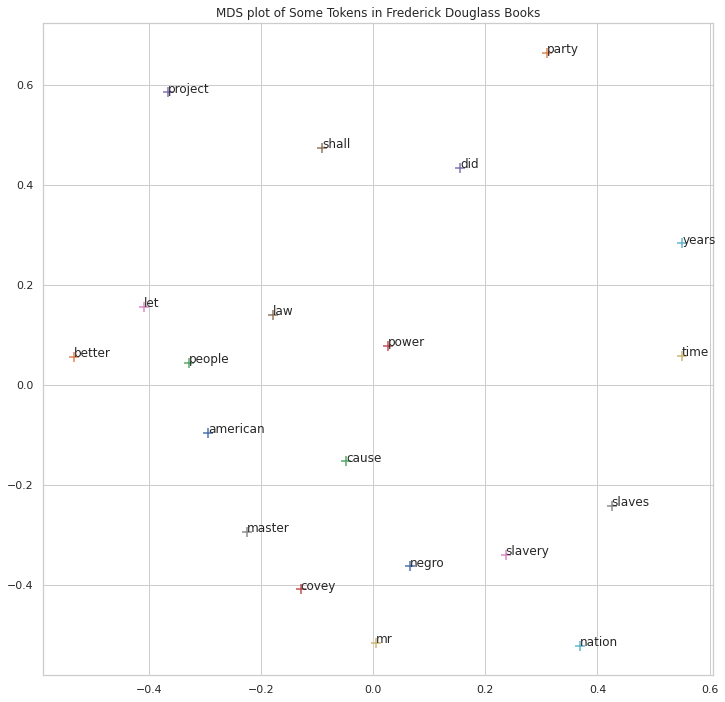

In [ ]:
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12,12))
i = 0
while i < len(tokenslimited_df.columns):
    plt.scatter(tokens_transform[i,0], tokens_transform[i,1], sizes=(100, 100), marker='+')
    plt.text(tokens_transform[i,0], tokens_transform[i,1], tokenslimited_df.columns[i])
    i += 1
plt.title('MDS plot of Some Tokens in Frederick Douglass Books')
plt.show()

In [ ]:
corpus3 = []
sentences3 = nltk.sent_tokenize(books['https://www.gutenberg.org/files/23/23-h/23-h.htm'])
corpus3.extend(sentences3)


In [ ]:
vectorizer2 = CountVectorizer(
    min_df=0.001, 
    max_df=0.7,  
    stop_words='english',
    ngram_range=(2,5)
    )

douglassNgram_tm = vectorizer2.fit_transform(sentences3)

douglassNgram_feature_names = vectorizer2.get_feature_names()

def termstats(dtm, vec):
    freqs = dtm.sum(axis=0).tolist()[0]
    docfreqs = np.bincount(dtm.indices)
    freq_df = pd.DataFrame(
        dict(frequency=freqs,docfreq=docfreqs),
        index=vec.get_feature_names())
    return freq_df.sort_values('frequency', ascending=False
    )

douglass_ts = termstats(douglassNgram_tm, vectorizer2)
douglass_ts.head(50)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,frequency,docfreq
colonel lloyd,36,34
st michael,16,16
old master,16,14
mr gore,14,13
master thomas,12,12
great house,11,11
frederick douglass,9,8
house farm,9,9
run away,9,9
colonel lloyd plantation,9,9


In [ ]:
douglassDense_tm = pd.DataFrame(douglassNgram_tm.todense(), columns=douglassNgram_feature_names)
douglassDense_tm.head()

,advice direction,aft marked,allowance day,allowance food,answer did,anti slavery,anti slavery society,approach day,approach white,ascertain views,...,wretched lot,wye town,year passed,yearly clothing,years age,years ago,years old,years old left,young barney,young man
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
douglassDense_tm.describe()

,advice direction,aft marked,allowance day,allowance food,answer did,anti slavery,anti slavery society,approach day,approach white,ascertain views,...,wretched lot,wye town,year passed,yearly clothing,years age,years ago,years old,years old left,young barney,young man
count,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,...,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000
mean,0.001425,0.001425,0.001425,0.001425,0.001425,0.004986,0.002137,0.001425,0.001425,0.001425,...,0.001425,0.001425,0.001425,0.001425,0.002849,0.001425,0.006410,0.001425,0.001425,0.004986
std,0.037729,0.037729,0.037729,0.037729,0.037729,0.079937,0.046192,0.037729,0.037729,0.037729,...,0.037729,0.037729,0.037729,0.037729,0.053319,0.037729,0.088313,0.037729,0.037729,0.070459
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000


In [ ]:
tokens_present = np.where(douglassDense_tm.max() > 1, True, False)
ngramslimited_df = douglassDense_tm.loc[:, tokens_present]
ngramslimited_df

,anti slavery,board sloop,colonel lloyd,colonel lloyd slaves,frederick douglass,lloyd slaves,master father,mr gore,old age,old master,wild beasts,work work,years old
0,0,0,0,0,2,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,0,0,0,0,0,0,0,0,0,0,0,0,0
1400,0,0,0,0,0,0,0,0,0,0,0,0,0
1401,0,0,0,0,0,0,0,0,0,0,0,0,0
1402,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ngrams_cofreq = ngramslimited_df.T.dot(ngramslimited_df)
ngrams_dist = 100 - ngrams_cofreq
ngrams_dist  # distance matrix 

,anti slavery,board sloop,colonel lloyd,colonel lloyd slaves,frederick douglass,lloyd slaves,master father,mr gore,old age,old master,wild beasts,work work,years old
anti slavery,91,100,100,100,98,100,100,100,100,100,100,100,100
board sloop,100,95,100,100,100,100,100,100,100,100,100,100,100
colonel lloyd,100,100,60,92,100,92,100,97,100,97,100,100,97
colonel lloyd slaves,100,100,92,92,100,92,100,99,100,100,100,100,100
frederick douglass,98,100,100,100,89,100,100,100,100,100,100,100,100
lloyd slaves,100,100,92,92,100,92,100,99,100,100,100,100,100
master father,100,100,100,100,100,100,93,100,100,100,100,100,100
mr gore,100,100,97,99,100,99,100,84,100,100,100,100,100
old age,100,100,100,100,100,100,100,100,94,98,100,100,100
old master,100,100,97,100,100,100,100,100,98,80,100,100,97


In [ ]:
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
ngrams_transform = mds.fit_transform(ngrams_dist)
print(mds.stress_)

1.8883698728632499


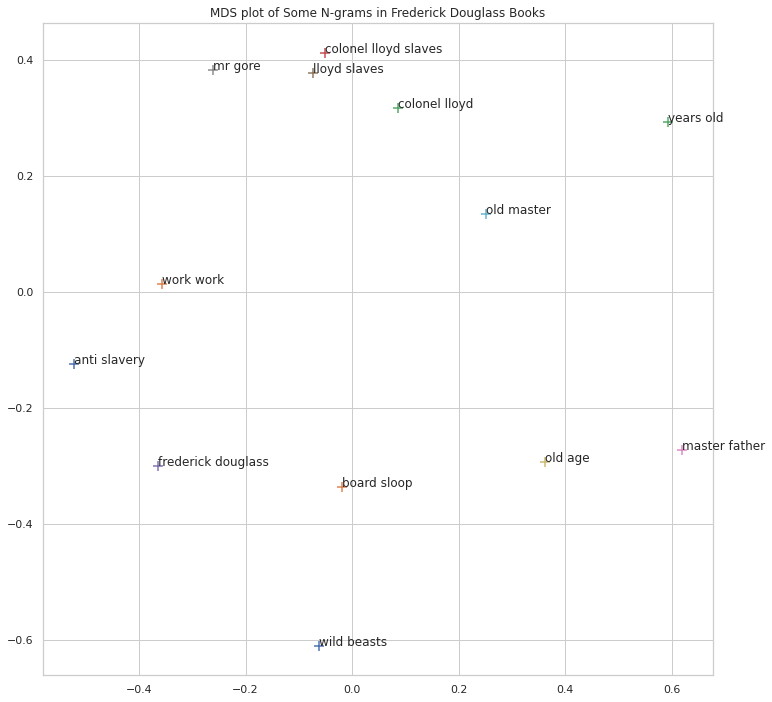

In [ ]:
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12,12))
i = 0
while i < len(ngramslimited_df.columns):
    plt.scatter(ngrams_transform[i,0], ngrams_transform[i,1], sizes=(100, 100), marker='+')
    plt.text(ngrams_transform[i,0], ngrams_transform[i,1], ngramslimited_df.columns[i])
    i += 1
plt.title('MDS plot of Some N-grams in Frederick Douglass Books')
plt.show()

## Activity

Identify a news feed as input data.

Read in the input and parse the text to make it available for coding.

Use the WordNet library to do content coding, as in the blocks above.

Visualize the results in a way that makes sense.

Interpret the analysis.